# CIFAR10 Classification

In this part of the assignment we want to do an image classification task using PyTorch on CIFAR10 dataset.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
from torchvision import transforms

## Device

Set device to work with (GPU or CPU)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Transforms & Dataset & Dataloader

Here, you should download and load the dataset with the desire transforms. After that, you should split train dataset to train and validation sets. Finally, define the dataloaders for `train`, `validation` and `test`

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(degrees=(0, 10)),
    transforms.RandomGrayscale(p = 0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
  ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.20, 0.20, 0.20))
  ])

In [ ]:
# inverse the normilize transform to restore the original data
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

norminv = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.20, 0.20, 0.20))

In [ ]:
initial_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

Files already downloaded and verified


In [ ]:
train_size = int(0.9 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = torch.utils.data.random_split(initial_trainset, (train_size, val_size))

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


## Visualization

Visualize 5 random images from each class in different columns

- **Hint**:  You can use `plt.subplots` for visualization

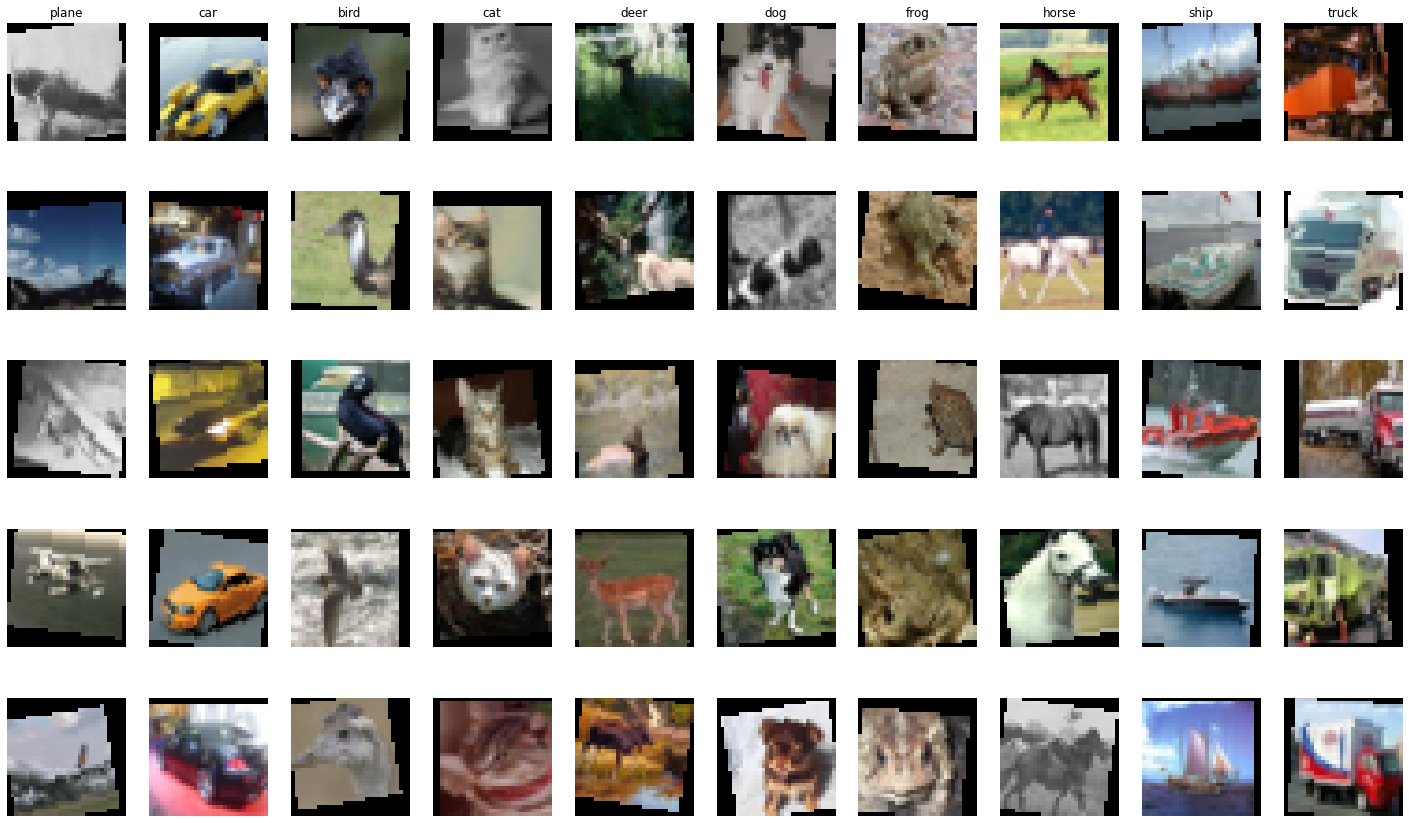

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))

no_row = 5
i = 0

for row in range(no_row):
    sample_row = 1
    for number, class_name in enumerate(classes):
      find = False
      while not find:
        image, label = trainset[i]
        if label == number:
          fig.add_subplot(no_row, 10, row * 10 + sample_row)
          plt.imshow(norminv(image).permute(1, 2, 0).numpy())
          plt.axis('off')
          sample_row += 1
          find = True
        i += 1
      if row == 0:
        plt.title(class_name)

plt.show()

## Model

Define your ResNet model here from scratch (You are not allowed to use the existing models in pytorch)

Our suggestion is to implement ResNet18

In [ ]:

class ResNetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU()
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.stride == 1:
            out += residual
        return self.relu(out)


class ResNet18(torch.nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu1 = torch.nn.ReLU()
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(64, 64, 2)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(512, 10)

    def make_layer(self, in_channels, out_channels, num_blocks, stride=1):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResNetBlock(in_channels, out_channels, stride))
            in_channels = out_channels
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


## Train

### Model instantiation

Create an instance of your model and move it to `device`

In [ ]:
net = ResNet18().to(device)

### Criterion & Optimizater

Define `criterion` and `optimizer` (Or `scheduler`)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)

### Train loop

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Train accuracy
  - Validation loss
  - Validation accuracy
- [ ] save train/validation loss and accuracy (of each epoch) in an array for later usage

In [ ]:
import tqdm
from time import time

In [ ]:
train_loss = list()
val_loss = list()

train_acc = list()
val_acc = list()

testset_wrong_res = list()

def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer,scheduler: torch.optim.lr_scheduler ,dataloader: torch.utils.data.DataLoader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            pbar.set_description(f'train:  Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    scheduler.step()
    train_loss.append(epoch_loss / (i + 1))
    train_acc.append((epoch_true * 100. / epoch_all).item())

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += float(loss)

            predictions = p.argmax(-1)
            epoch_all += len(predictions)
            epoch_true += (predictions == y).sum()

            if test_mode:
                for x_sample, y_sample, y_pred in zip(x, y, predictions):
                    if y_pred != y_sample:
                        testset_wrong_res.append((x_sample, y_sample , y_pred))


            pbar.set_description(f'val: Loss: {epoch_loss / (i + 1):.3e} - Acc: {epoch_true * 100. / epoch_all:.2f}%')

    if not test_mode:
      val_loss.append(epoch_loss / (i + 1))
      val_acc.append((epoch_true * 100. / epoch_all).item())


In [ ]:
epochs = 100

for e in range(epochs):

    start_time = time()

    train_epoch(net, criterion, optimizer, scheduler, trainloader)
    eval_epoch(net, criterion, valloader)

    end_time = time()
    print()
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

val: Loss: 1.441e+00 - Acc: 48.56%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch   1 finished in 21.92s



val: Loss: 1.237e+00 - Acc: 57.04%: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


Epoch   2 finished in 22.86s



val: Loss: 1.153e+00 - Acc: 60.56%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch   3 finished in 22.05s



val: Loss: 9.895e-01 - Acc: 65.78%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch   4 finished in 22.21s



val: Loss: 9.269e-01 - Acc: 68.78%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch   5 finished in 22.02s



val: Loss: 1.003e+00 - Acc: 66.36%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch   6 finished in 22.05s



val: Loss: 8.560e-01 - Acc: 71.04%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch   7 finished in 22.10s



val: Loss: 7.628e-01 - Acc: 73.68%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch   8 finished in 22.41s



val: Loss: 7.481e-01 - Acc: 74.22%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch   9 finished in 22.93s



val: Loss: 7.351e-01 - Acc: 75.16%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  10 finished in 22.10s



val: Loss: 7.654e-01 - Acc: 75.00%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  11 finished in 22.27s



val: Loss: 7.286e-01 - Acc: 75.64%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  12 finished in 22.21s



val: Loss: 6.765e-01 - Acc: 76.58%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  13 finished in 21.94s



val: Loss: 7.020e-01 - Acc: 76.80%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  14 finished in 22.24s



val: Loss: 6.346e-01 - Acc: 79.16%: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch  15 finished in 22.93s



val: Loss: 6.696e-01 - Acc: 77.90%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  16 finished in 22.04s



val: Loss: 6.284e-01 - Acc: 79.14%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  17 finished in 21.94s



val: Loss: 6.342e-01 - Acc: 78.76%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  18 finished in 22.31s



val: Loss: 5.583e-01 - Acc: 81.34%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  19 finished in 22.24s



val: Loss: 5.845e-01 - Acc: 80.88%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  20 finished in 21.87s



val: Loss: 5.582e-01 - Acc: 81.46%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  21 finished in 22.68s



val: Loss: 6.615e-01 - Acc: 78.76%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  22 finished in 22.00s



val: Loss: 5.411e-01 - Acc: 81.60%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  23 finished in 22.21s



val: Loss: 6.556e-01 - Acc: 78.76%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  24 finished in 22.35s



val: Loss: 5.272e-01 - Acc: 82.60%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  25 finished in 22.14s



val: Loss: 4.775e-01 - Acc: 84.62%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  26 finished in 22.07s



val: Loss: 4.814e-01 - Acc: 84.48%: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  27 finished in 22.79s



val: Loss: 4.491e-01 - Acc: 85.40%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  28 finished in 21.75s



val: Loss: 4.813e-01 - Acc: 85.24%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  29 finished in 22.05s



val: Loss: 4.643e-01 - Acc: 85.08%: 100%|██████████| 5/5 [00:02<00:00,  2.27it/s]


Epoch  30 finished in 21.59s



val: Loss: 5.078e-01 - Acc: 84.24%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  31 finished in 22.35s



val: Loss: 4.748e-01 - Acc: 84.76%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  32 finished in 22.29s



val: Loss: 4.622e-01 - Acc: 85.36%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  33 finished in 22.35s



val: Loss: 5.038e-01 - Acc: 84.96%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch  34 finished in 22.96s



val: Loss: 5.035e-01 - Acc: 84.42%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  35 finished in 21.56s



val: Loss: 4.895e-01 - Acc: 85.14%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  36 finished in 22.09s



val: Loss: 4.693e-01 - Acc: 85.12%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  37 finished in 22.40s



val: Loss: 4.800e-01 - Acc: 85.42%: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


Epoch  38 finished in 21.82s



val: Loss: 4.551e-01 - Acc: 85.80%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  39 finished in 21.58s



val: Loss: 4.669e-01 - Acc: 85.80%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  40 finished in 22.90s



val: Loss: 4.936e-01 - Acc: 85.16%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  41 finished in 22.04s



val: Loss: 4.598e-01 - Acc: 86.58%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  42 finished in 22.32s



val: Loss: 5.032e-01 - Acc: 85.26%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  43 finished in 21.80s



val: Loss: 4.929e-01 - Acc: 85.04%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  44 finished in 21.91s



val: Loss: 4.860e-01 - Acc: 85.46%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  45 finished in 21.98s



val: Loss: 4.750e-01 - Acc: 85.66%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  46 finished in 22.74s



val: Loss: 5.111e-01 - Acc: 85.06%: 100%|██████████| 5/5 [00:02<00:00,  2.22it/s]


Epoch  47 finished in 22.60s



val: Loss: 4.938e-01 - Acc: 85.74%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  48 finished in 22.35s



val: Loss: 5.019e-01 - Acc: 85.20%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  49 finished in 21.93s



val: Loss: 4.811e-01 - Acc: 86.20%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  50 finished in 22.32s



val: Loss: 4.704e-01 - Acc: 86.16%: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch  51 finished in 21.74s



val: Loss: 4.817e-01 - Acc: 86.40%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  52 finished in 22.83s



val: Loss: 4.752e-01 - Acc: 87.16%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  53 finished in 21.44s



val: Loss: 4.645e-01 - Acc: 86.72%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  54 finished in 22.20s



val: Loss: 4.642e-01 - Acc: 87.08%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch  55 finished in 21.50s



val: Loss: 4.866e-01 - Acc: 86.44%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  56 finished in 21.42s



val: Loss: 4.768e-01 - Acc: 86.80%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  57 finished in 22.22s



val: Loss: 5.308e-01 - Acc: 86.16%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  58 finished in 21.86s



val: Loss: 5.035e-01 - Acc: 86.58%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  59 finished in 22.48s



val: Loss: 5.325e-01 - Acc: 86.36%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  60 finished in 22.11s



val: Loss: 5.128e-01 - Acc: 86.24%: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


Epoch  61 finished in 21.76s



val: Loss: 5.012e-01 - Acc: 86.34%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  62 finished in 21.29s



val: Loss: 4.956e-01 - Acc: 86.78%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  63 finished in 22.12s



val: Loss: 4.984e-01 - Acc: 86.90%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch  64 finished in 21.80s



val: Loss: 5.178e-01 - Acc: 87.24%: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch  65 finished in 22.95s



val: Loss: 5.154e-01 - Acc: 86.68%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  66 finished in 22.08s



val: Loss: 5.045e-01 - Acc: 87.18%: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch  67 finished in 21.84s



val: Loss: 5.174e-01 - Acc: 87.22%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  68 finished in 21.99s



val: Loss: 5.196e-01 - Acc: 86.92%: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch  69 finished in 21.87s



val: Loss: 5.152e-01 - Acc: 86.62%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  70 finished in 21.68s



val: Loss: 4.989e-01 - Acc: 87.30%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  71 finished in 22.81s



val: Loss: 5.534e-01 - Acc: 86.76%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  72 finished in 22.00s



val: Loss: 5.373e-01 - Acc: 86.04%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  73 finished in 21.81s



val: Loss: 5.242e-01 - Acc: 87.20%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch  74 finished in 22.04s



val: Loss: 5.111e-01 - Acc: 87.24%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  75 finished in 21.83s



val: Loss: 5.168e-01 - Acc: 87.50%: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


Epoch  76 finished in 21.51s



val: Loss: 5.132e-01 - Acc: 87.42%: 100%|██████████| 5/5 [00:02<00:00,  2.15it/s]


Epoch  77 finished in 22.81s



val: Loss: 4.917e-01 - Acc: 87.90%: 100%|██████████| 5/5 [00:02<00:00,  2.30it/s]


Epoch  78 finished in 22.13s



val: Loss: 5.174e-01 - Acc: 86.94%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  79 finished in 22.04s



val: Loss: 5.069e-01 - Acc: 87.56%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  80 finished in 22.02s



val: Loss: 5.451e-01 - Acc: 87.10%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  81 finished in 21.55s



val: Loss: 5.235e-01 - Acc: 86.96%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  82 finished in 21.95s



val: Loss: 5.306e-01 - Acc: 87.76%: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch  83 finished in 21.53s



val: Loss: 5.359e-01 - Acc: 87.08%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  84 finished in 22.52s



val: Loss: 5.445e-01 - Acc: 87.30%: 100%|██████████| 5/5 [00:02<00:00,  2.35it/s]


Epoch  85 finished in 21.91s



val: Loss: 5.113e-01 - Acc: 87.48%: 100%|██████████| 5/5 [00:02<00:00,  2.31it/s]


Epoch  86 finished in 22.09s



val: Loss: 5.195e-01 - Acc: 87.98%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  87 finished in 21.80s



val: Loss: 5.138e-01 - Acc: 87.96%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  88 finished in 22.39s



val: Loss: 5.285e-01 - Acc: 87.74%: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


Epoch  89 finished in 21.82s



val: Loss: 5.652e-01 - Acc: 86.96%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  90 finished in 23.21s



val: Loss: 5.689e-01 - Acc: 86.82%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  91 finished in 22.02s



val: Loss: 5.724e-01 - Acc: 87.50%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  92 finished in 22.33s



val: Loss: 5.628e-01 - Acc: 86.94%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch  93 finished in 22.21s



val: Loss: 5.483e-01 - Acc: 87.12%: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


Epoch  94 finished in 22.16s



val: Loss: 5.413e-01 - Acc: 87.54%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  95 finished in 21.81s



val: Loss: 5.672e-01 - Acc: 87.80%: 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


Epoch  96 finished in 23.49s



val: Loss: 5.494e-01 - Acc: 87.38%: 100%|██████████| 5/5 [00:02<00:00,  2.24it/s]


Epoch  97 finished in 22.47s



val: Loss: 5.102e-01 - Acc: 88.44%: 100%|██████████| 5/5 [00:02<00:00,  2.29it/s]


Epoch  98 finished in 22.48s



val: Loss: 5.467e-01 - Acc: 87.38%: 100%|██████████| 5/5 [00:02<00:00,  2.25it/s]


Epoch  99 finished in 22.27s



val: Loss: 5.841e-01 - Acc: 86.82%: 100%|██████████| 5/5 [00:02<00:00,  2.26it/s]


Epoch 100 finished in 22.00s


In [ ]:
# save net params to avoid training time
torch.save(net.state_dict(), 'net.pth')

In [ ]:
# load net params after reset the net
net.load_state_dict(torch.load('net.pth'))

<All keys matched successfully>

### Visualize Loss and Accuracy plot

Using the arrays that you have (from task 2 in the above section), visualize two plots: Accuracy plot (train and validation together) and Loss plot (train and validation together)

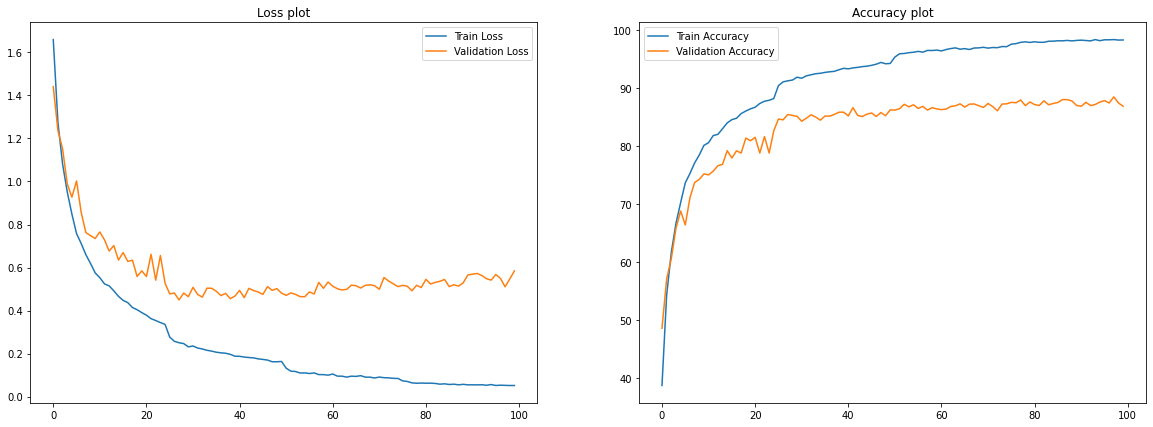

In [ ]:
x = range(len(train_loss))

fig = plt.figure(figsize=(20, 7))

fig.add_subplot(1, 2, 1)
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.title('Loss plot')
plt.legend(['Train Loss', 'Validation Loss'])

fig.add_subplot(1, 2, 2)
plt.plot(x, train_acc)
plt.plot(x, val_acc)
plt.title('Accuracy plot')
plt.legend(['Train Accuracy', 'Validation Accuracy'])

plt.show()

## Evaluation

Test your trained model (using the Test Dataloader that you have). Our goal is to reach an accuracy above `90%`

In [ ]:
testset_wrong_res = list()

eval_epoch(net, criterion, testloader, test_mode= True)

val: Loss: 5.163e-01 - Acc: 89.70%: 100%|██████████| 10/10 [00:03<00:00,  3.25it/s]


## Visualize incorrectly predicted samples from testset

Visualize *24* random images from testset that are incorrectly predicted by the model

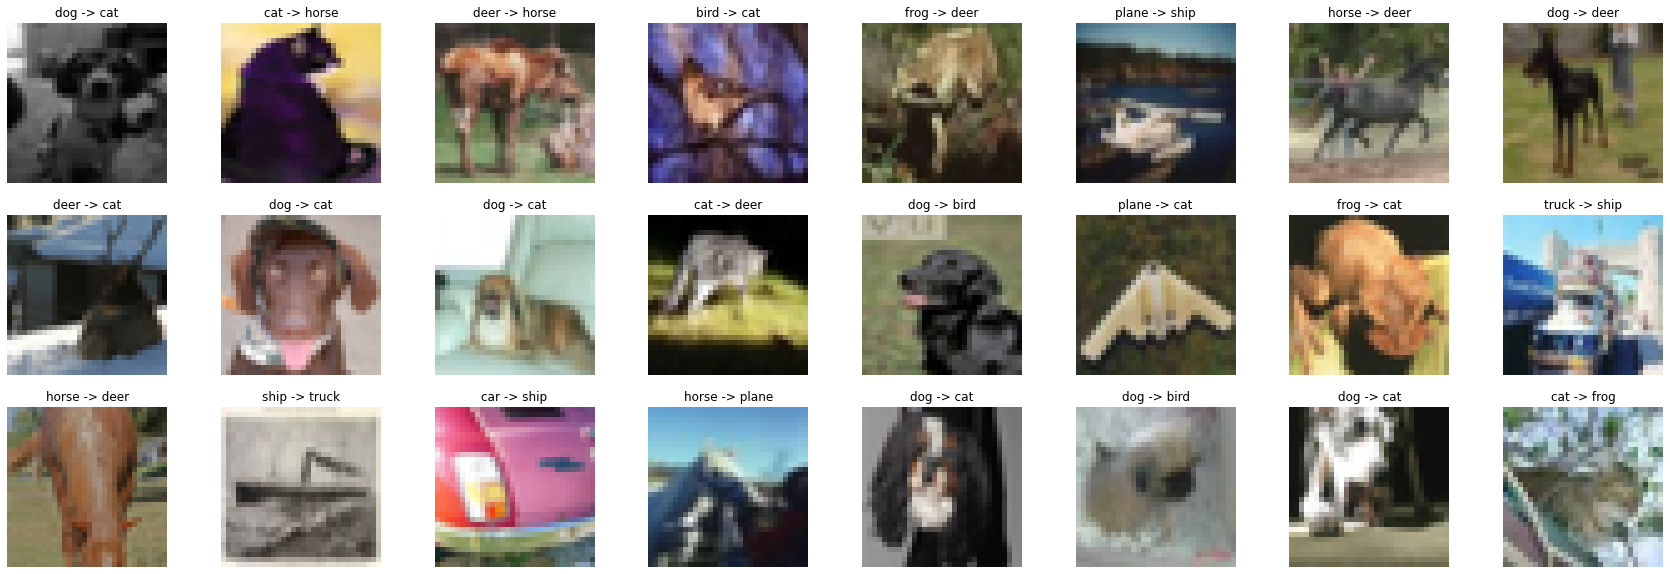

In [ ]:
import random

wrong_set = random.sample(testset_wrong_res, 24)

fig = plt.figure(figsize=(30, 10))

for i, wrong in enumerate(wrong_set):
  image, true_label, pred_label = wrong
  fig.add_subplot(3, 8, i + 1)
  plt.imshow(norminv((image.clone()).cpu()).permute(1, 2, 0).numpy())
  plt.title(f"{classes[true_label]} -> {classes[pred_label]}")
  plt.axis('off')

plt.show()

## Exploring the feature space

### Calculate the feature space for all training samples

You have trained and evaluated your model. Now, for each sample in the trainset, calculate it's "feature space" discussed in the model section. The result of this section should be a tensor of size `(50000, N)` saved in a variable (for later usage)

- **Hint 1:** define a tensor with dimension `(50000, N)` where *50000* is the size of the trainset and *N* is the dimension of the feature space

- **Hint 2:** Pay attension to the `shuffle` attribute of your train dataloader (If needed)

In [ ]:
# load all training set
all_train_loader = torch.utils.data.DataLoader(initial_trainset, batch_size=256,
                                          shuffle=False, num_workers=2)

In [ ]:
feature_set = list()

handle = net.fc.register_forward_hook(lambda m, i, o: feature_set.append(i[0]))

x_list = list()
y_list = list()

net.eval()
with torch.no_grad():
      for x, y in all_train_loader:
          x = x.to(device)
          y = y.to(device)

          x_list.append(x)
          y_list.append(y)

          p = net(x)

handle.remove()



In [ ]:
all_x_y = list()
all_fs = None
all_fs = torch.cat([f for f  in feature_set])
for datas, labels in zip(x_list, y_list):
  all_x_y += list(zip(datas, labels))

len(all_x_y)

50000

In [ ]:
all_fs.shape

torch.Size([50000, 512])

### K Nearest Neighbor in feature space

You already have calculated the feature spaces for trainset ($S$) in the previous section

1. Get 5 random samples from testset which are correctly predicted by the model.
2. for each sample, calculate it's "feature space" ($X$)
3. for each sample, calculate it's *5* nearest neighbors in "feature space" in the trainset (by comparing $X$ to each row in $S$) and visualize them

**Note:** Your visualization should be something like the below picture

**Hint:** For finding the nearest neighbors in the feature space you can use `torch.linalg.norm` and `torch.topk`

In [ ]:
# get
correct_test = list()
test_feature = list()

handle = net.fc.register_forward_hook(lambda m, i, o: test_feature.append(i[0]))

net.eval()
with torch.no_grad():
    for i ,(x, y) in enumerate(testloader):
        x = x.to(device)
        y = y.to(device)
        p = net(x)
        predictions = p.argmax(-1)

        for x_sample, y_sample, y_pred, feature in zip(x, y, predictions, test_feature[i]):
          if y_pred == y_sample:
            correct_test.append((x_sample, y_sample , feature))

handle.remove()

In [ ]:
all_nearest = list()

random_samples = random.sample(correct_test, 5)

k = 5

for sample in random_samples:
  feature_vect = sample[2]
  all_dists = (all_fs - feature_vect)
  res = torch.norm(all_dists, dim=1)
  near_features, indexes = res.topk(k, largest= False)
  nearest = [all_x_y[i] for i in indexes.tolist()]
  all_nearest.append(nearest)


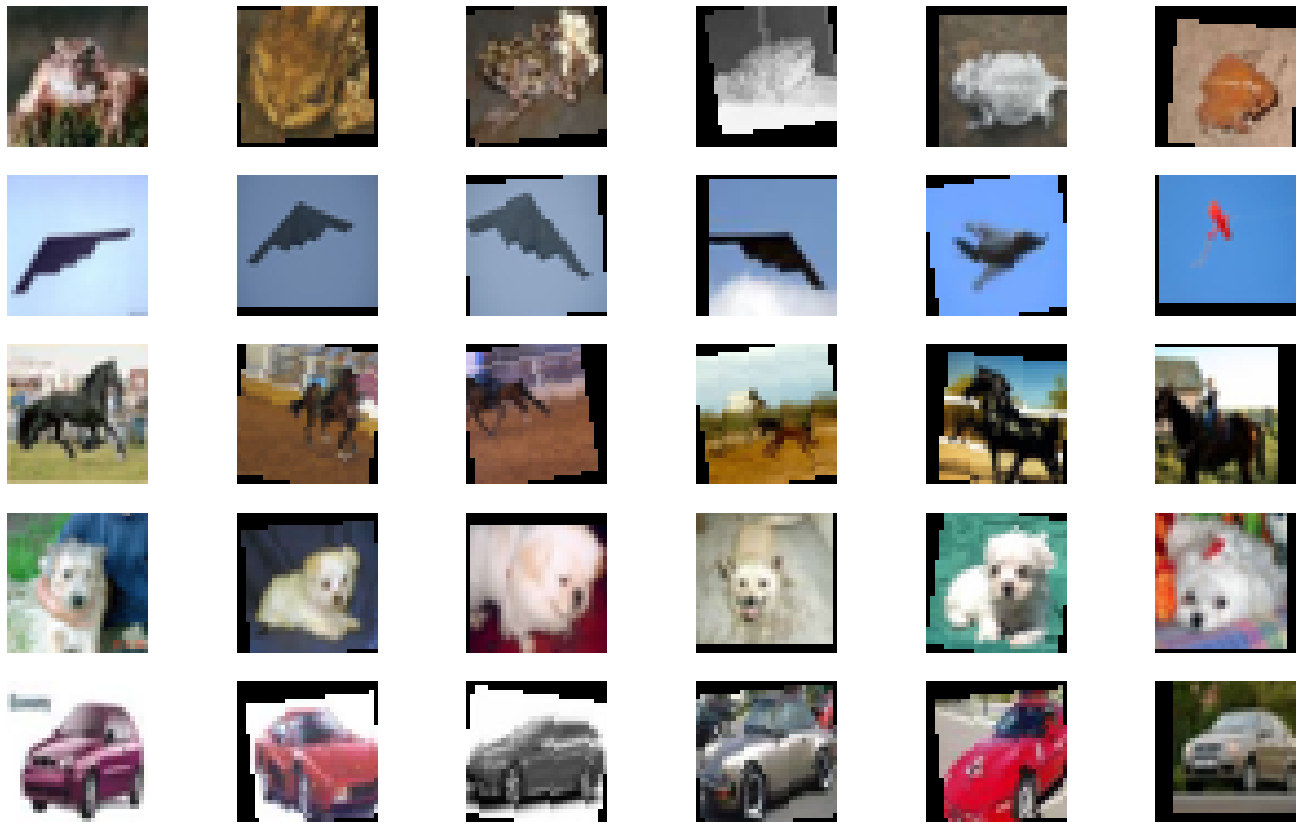

In [ ]:
fig = plt.figure(figsize = (24,15))

for i in range(5):
    for j in range(6):
      fig.add_subplot(5, 6, i*6 + j + 1)
      if j == 0:
        img = random_samples[i][0]
      else:
        img = all_nearest[i][j-1][0]
      plt.imshow(norminv((img.clone()).cpu()).permute(1, 2, 0).numpy())
      plt.axis('off')

plt.show()

### TSNE

1. Sample $M$ ($2000$ would be enought) random samples from the trainset feature space (calculated in the above sections)
2. Now you a vector of size `(M, N)` where $N$ is the dimension of the feature space
3. Using TSNE reduce $N$ to $2$ (Now you have a vector of size `(M, 2)`)
4. Print the shape of the output

**Hint:** You can use `sklearn.manifold.TSNE`

In [ ]:
m = 2000
perm = torch.randperm(all_fs.size(0))
idx = perm[:m]
m_samples = all_fs[idx]
m_samples = m_samples.cpu()

In [ ]:
sample_labels = [all_x_y[i][1].cpu().item() for i in idx.tolist()]

In [ ]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(m_samples)

X_embedded.shape

(2000, 2)

Visualize the points in a 2D plane (Set color of each point based on it's class)

**Notice:** Your visualization should be something like the below image

**Hint:** Use `plt.scatter(x, y, c=labels)`

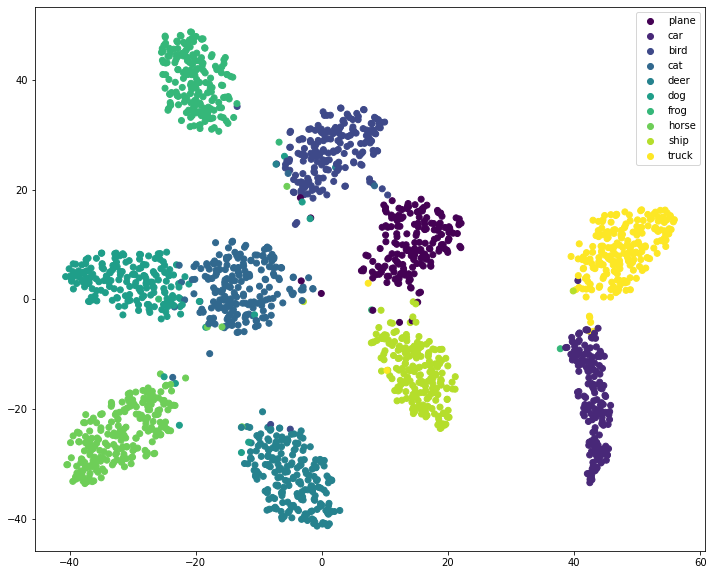

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(X_embedded[:,0], X_embedded[:,1], c=sample_labels)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()

# CIFAR10 Colorization

In this part of the assignment, we want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [ ]:
class BlackAndWhiteCIFAR10(Dataset):
    """
    Define a custom dataset class by extending `torch.utils.data.Dataset`
    this class is a dataset for the CIFAR10 data in pytorch and it has the black and white image of the original CIFAR10 image as the data
    and the original RGB image as the target
    this class is just a wrapper for the torchvision.datasets.CIFAR10 class
    """

    def __init__(self, train=True, root='./data', download=True, transform=None):
        self.data = torchvision.datasets.CIFAR10(root=root, train=train, download=download, transform=transform)
        self.mode = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torchvision.transforms.Grayscale()(self.data[index][0]), self.data[index][0]


## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [ ]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
  ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
  ])

In [ ]:
initial_trainset = BlackAndWhiteCIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
train_size = int(0.9 * len(initial_trainset))
val_size = len(initial_trainset) - train_size
trainset, valset = torch.utils.data.random_split(initial_trainset, (train_size, val_size))

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=1024,
                                         shuffle=False, num_workers=2)

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

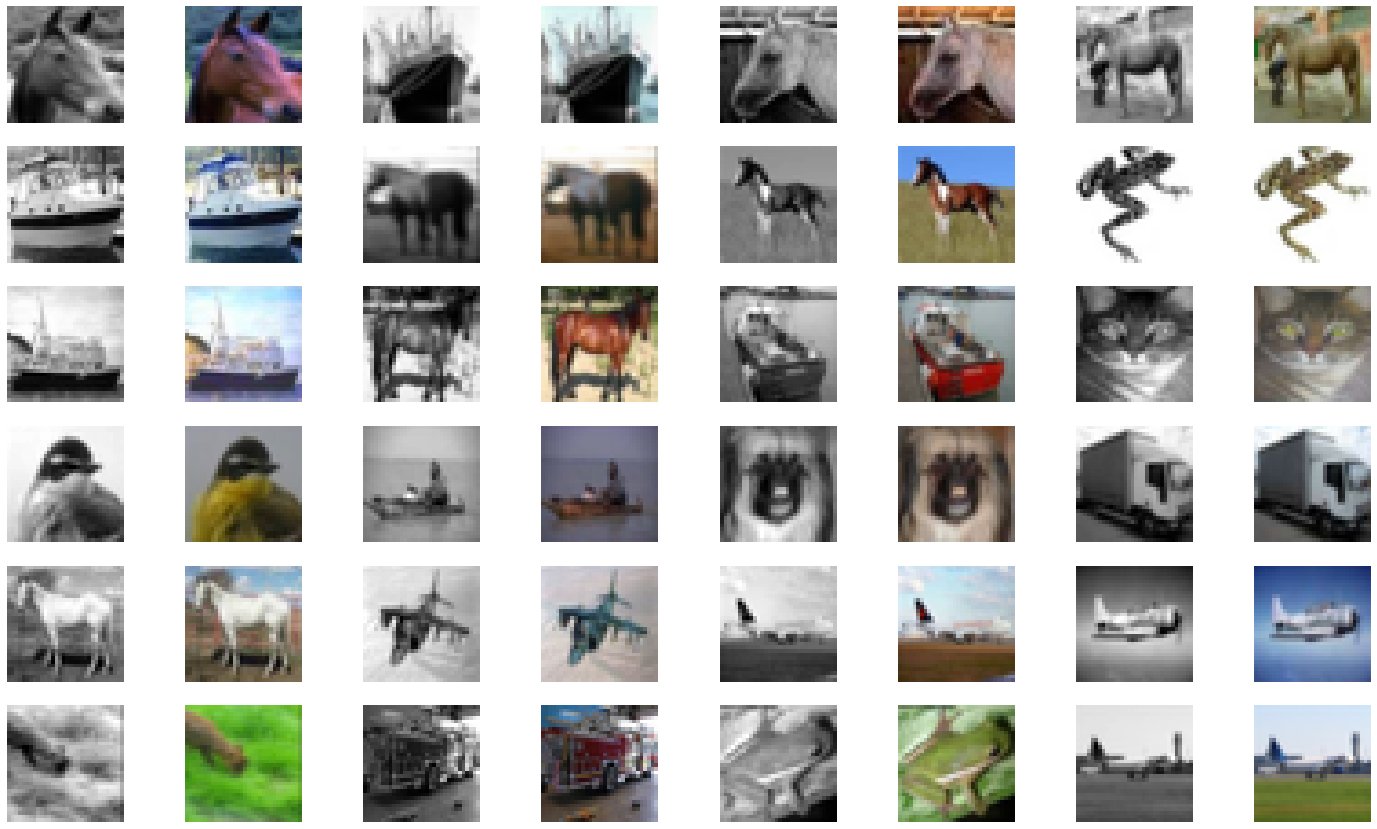

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25, 15))


cols, rows = 8, 6
for i in range(1, rows*cols+1,2):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    bw_img, rgb_image = trainset[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow((bw_img.clone()).numpy().reshape(32,32),cmap='gray')
    plt.axis("off")
    fig.add_subplot(rows, cols, i+1)
    plt.imshow((rgb_image.clone()).permute(1, 2, 0).numpy())
    plt.axis("off")
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option

In [ ]:

import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=4, stride=2, padding=1, dropout=0, activation_fn=nn.LeakyReLU(0.2)):
        super(ConvBlock, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_size),
            activation_fn
        )
        if dropout != 0:
            self.model = nn.Sequential(
                self.model,
                nn.Dropout(dropout)
            )

    def forward(self, x):
        x = self.model(x)
        return x

class TransConvBlock(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=4, stride=2, padding=1, dropout=0.0, activation_fn=nn.ReLU()):
        super(TransConvBlock, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_size, out_size, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_size),
            activation_fn
        )
        if dropout != 0:
          self.model = nn.Sequential(
              self.model,
              nn.Dropout(dropout)
          )

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class colorizationNet(nn.Module):
    def __init__(self):
        super(colorizationNet, self).__init__()

        self.down1 = ConvBlock(1, 64, kernel_size=4, stride=1, padding=0, dropout=0)
        self.down2 = ConvBlock(64, 128, kernel_size=4, stride=2, padding=1, dropout=0)
        self.down3 = ConvBlock(128, 256, kernel_size=4, stride=2, padding=1, dropout=0)
        self.down4 = ConvBlock(256, 512, kernel_size=4, stride=2, padding=1, dropout=0)
        self.down5 = ConvBlock(512, 512, kernel_size=4, stride=2, padding=1, dropout=0)

        self.up1 = TransConvBlock(512, 512, kernel_size=4, stride=2, padding=1, dropout=0.5)
        self.up2 = TransConvBlock(1024, 256, kernel_size=4, stride=2, padding=1, dropout=0.5)
        self.up3 = TransConvBlock(512, 128, kernel_size=4, stride=2, padding=1, dropout=0)
        self.up4 = TransConvBlock(256, 64, kernel_size=4, stride=2, padding=1, dropout=0)
        self.final = ConvBlock(128, 3, kernel_size=1, stride=1, padding=0, dropout=0, activation_fn=nn.Tanh())

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(35, 35), mode='bilinear', align_corners=True)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)

        u1 = self.up1(d5, d4)
        u2 = self.up2(u1, d3)
        u3 = self.up3(u2, d2)
        u4 = self.up4(u3, d1)

        x = self.final(u4)
        return x

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [ ]:
net = colorizationNet().to(device)

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
import tqdm
from time import time

In [ ]:
train_loss = list()
val_loss = list()

def train_epoch(net: torch.nn.Module, criterion: torch.nn.Module, optimizer: torch.optim.Optimizer ,dataloader: torch.utils.data.DataLoader):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.train()
    with tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)
            epoch_loss += loss.item()

            pbar.set_description(f'train: MSE Loss: {epoch_loss / (i + 1):.3e}')

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    train_loss.append(epoch_loss / (i + 1))

def eval_epoch(net: torch.nn.Module, criterion: torch.nn.Module, dataloader: torch.utils.data.DataLoader, test_mode: bool = False):
    epoch_loss = 0
    epoch_true = 0
    epoch_all = 0
    i = 0

    net.eval()
    with torch.no_grad(), tqdm.tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
        for i, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)
            p = net(x)

            loss = criterion(p, y)

            epoch_loss += loss.item()

            pbar.set_description(f'val: MSE Loss: {epoch_loss / (i + 1):.3e}')

    if not test_mode:
      val_loss.append(epoch_loss / (i + 1))


In [ ]:
epochs = 75

for e in range(epochs):

    start_time = time()

    train_epoch(net, criterion, optimizer, trainloader)
    eval_epoch(net, criterion, valloader)

    end_time = time()
    print()
    print(f'Epoch {e+1:3} finished in {end_time - start_time:.2f}s')

val: MSE Loss: 8.819e-02: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]


Epoch   1 finished in 65.13s



val: MSE Loss: 6.329e-02: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]


Epoch   2 finished in 71.02s



val: MSE Loss: 4.900e-02: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch   3 finished in 71.19s



val: MSE Loss: 3.965e-02: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch   4 finished in 72.03s



val: MSE Loss: 2.450e-02: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch   5 finished in 72.05s



val: MSE Loss: 1.939e-02: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch   6 finished in 71.76s



val: MSE Loss: 1.611e-02: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch   7 finished in 72.06s



val: MSE Loss: 1.476e-02: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch   8 finished in 71.80s



val: MSE Loss: 1.050e-02: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch   9 finished in 72.24s



val: MSE Loss: 1.357e-02: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  10 finished in 72.17s



val: MSE Loss: 9.715e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  11 finished in 72.18s



val: MSE Loss: 9.174e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  12 finished in 72.22s



val: MSE Loss: 7.617e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  13 finished in 71.85s



val: MSE Loss: 7.235e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  14 finished in 72.00s



val: MSE Loss: 7.443e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  15 finished in 72.19s



val: MSE Loss: 6.976e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  16 finished in 72.05s



val: MSE Loss: 6.797e-03: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch  17 finished in 72.13s



val: MSE Loss: 6.562e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  18 finished in 72.30s



val: MSE Loss: 6.572e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  19 finished in 71.94s



val: MSE Loss: 6.227e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  20 finished in 71.83s



val: MSE Loss: 6.112e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  21 finished in 71.97s



val: MSE Loss: 6.720e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  22 finished in 72.04s



val: MSE Loss: 6.256e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  23 finished in 71.70s



val: MSE Loss: 7.321e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  24 finished in 71.95s



val: MSE Loss: 6.990e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  25 finished in 72.21s



val: MSE Loss: 6.400e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  26 finished in 72.24s



val: MSE Loss: 7.273e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  27 finished in 72.04s



val: MSE Loss: 6.053e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  28 finished in 72.04s



val: MSE Loss: 6.024e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  29 finished in 72.11s



val: MSE Loss: 5.827e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  30 finished in 71.99s



val: MSE Loss: 5.947e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  31 finished in 72.12s



val: MSE Loss: 6.485e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  32 finished in 71.62s



val: MSE Loss: 5.940e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  33 finished in 71.64s



val: MSE Loss: 5.863e-03: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch  34 finished in 71.93s



val: MSE Loss: 5.864e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  35 finished in 72.03s



val: MSE Loss: 6.434e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  36 finished in 72.02s



val: MSE Loss: 6.022e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  37 finished in 72.11s



val: MSE Loss: 6.377e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  38 finished in 71.81s



val: MSE Loss: 6.417e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  39 finished in 71.59s



val: MSE Loss: 6.462e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  40 finished in 71.78s



val: MSE Loss: 5.813e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  41 finished in 71.98s



val: MSE Loss: 6.015e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  42 finished in 72.07s



val: MSE Loss: 7.689e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  43 finished in 71.94s



val: MSE Loss: 7.093e-03: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  44 finished in 72.03s



val: MSE Loss: 6.106e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  45 finished in 71.91s



val: MSE Loss: 6.455e-03: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch  46 finished in 71.99s



val: MSE Loss: 5.931e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  47 finished in 71.83s



val: MSE Loss: 6.147e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  48 finished in 71.79s



val: MSE Loss: 6.305e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  49 finished in 71.82s



val: MSE Loss: 6.220e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  50 finished in 72.06s



val: MSE Loss: 6.006e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  51 finished in 72.01s



val: MSE Loss: 6.096e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  52 finished in 72.02s



val: MSE Loss: 6.787e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  53 finished in 72.18s



val: MSE Loss: 6.497e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  54 finished in 71.99s



val: MSE Loss: 6.111e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  55 finished in 71.80s



val: MSE Loss: 6.389e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  56 finished in 71.76s



val: MSE Loss: 6.950e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  57 finished in 71.97s



val: MSE Loss: 6.193e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  58 finished in 71.87s



val: MSE Loss: 6.606e-02: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Epoch  59 finished in 72.13s



val: MSE Loss: 7.036e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  60 finished in 71.61s



val: MSE Loss: 6.585e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  61 finished in 71.58s



val: MSE Loss: 6.709e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  62 finished in 71.64s



val: MSE Loss: 6.507e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  63 finished in 71.68s



val: MSE Loss: 6.650e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  64 finished in 71.70s



val: MSE Loss: 6.378e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  65 finished in 71.61s



val: MSE Loss: 6.408e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  66 finished in 71.67s



val: MSE Loss: 6.515e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  67 finished in 71.75s



val: MSE Loss: 7.459e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  68 finished in 71.70s



val: MSE Loss: 6.439e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  69 finished in 71.84s



val: MSE Loss: 6.348e-03: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Epoch  70 finished in 71.98s



val: MSE Loss: 6.431e-03: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]


Epoch  71 finished in 72.01s



val: MSE Loss: 6.773e-03: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Epoch  72 finished in 71.86s



val: MSE Loss: 6.434e-03: 100%|██████████| 5/5 [00:03<00:00,  1.63it/s]


Epoch  73 finished in 71.61s



val: MSE Loss: 6.329e-03: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Epoch  74 finished in 71.58s



val: MSE Loss: 6.384e-03: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Epoch  75 finished in 71.76s


### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

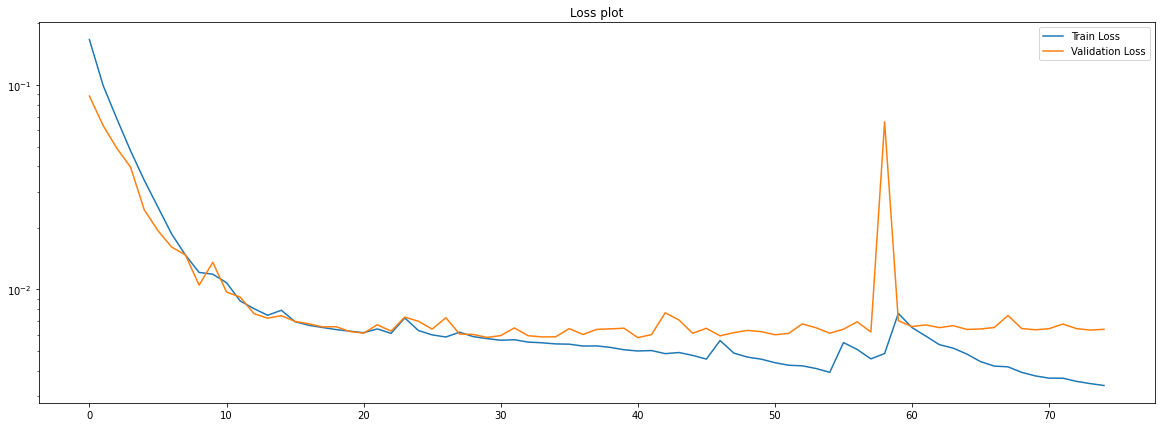

In [ ]:
x = range(len(train_loss))

fig = plt.figure(figsize=(20, 7))
plt.plot(x, train_loss)
plt.plot(x, val_loss)
plt.yscale('log')
plt.title('Loss plot')
plt.legend(['Train Loss', 'Validation Loss'])

plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



In [ ]:
testset = BlackAndWhiteCIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=36,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
test_net_res = list()

net.eval()
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        y = y.to(device)
        p = net(x)
        for bw, rgb, colored in zip(x, y, p):
            test_net_res.append((bw, rgb, colored))

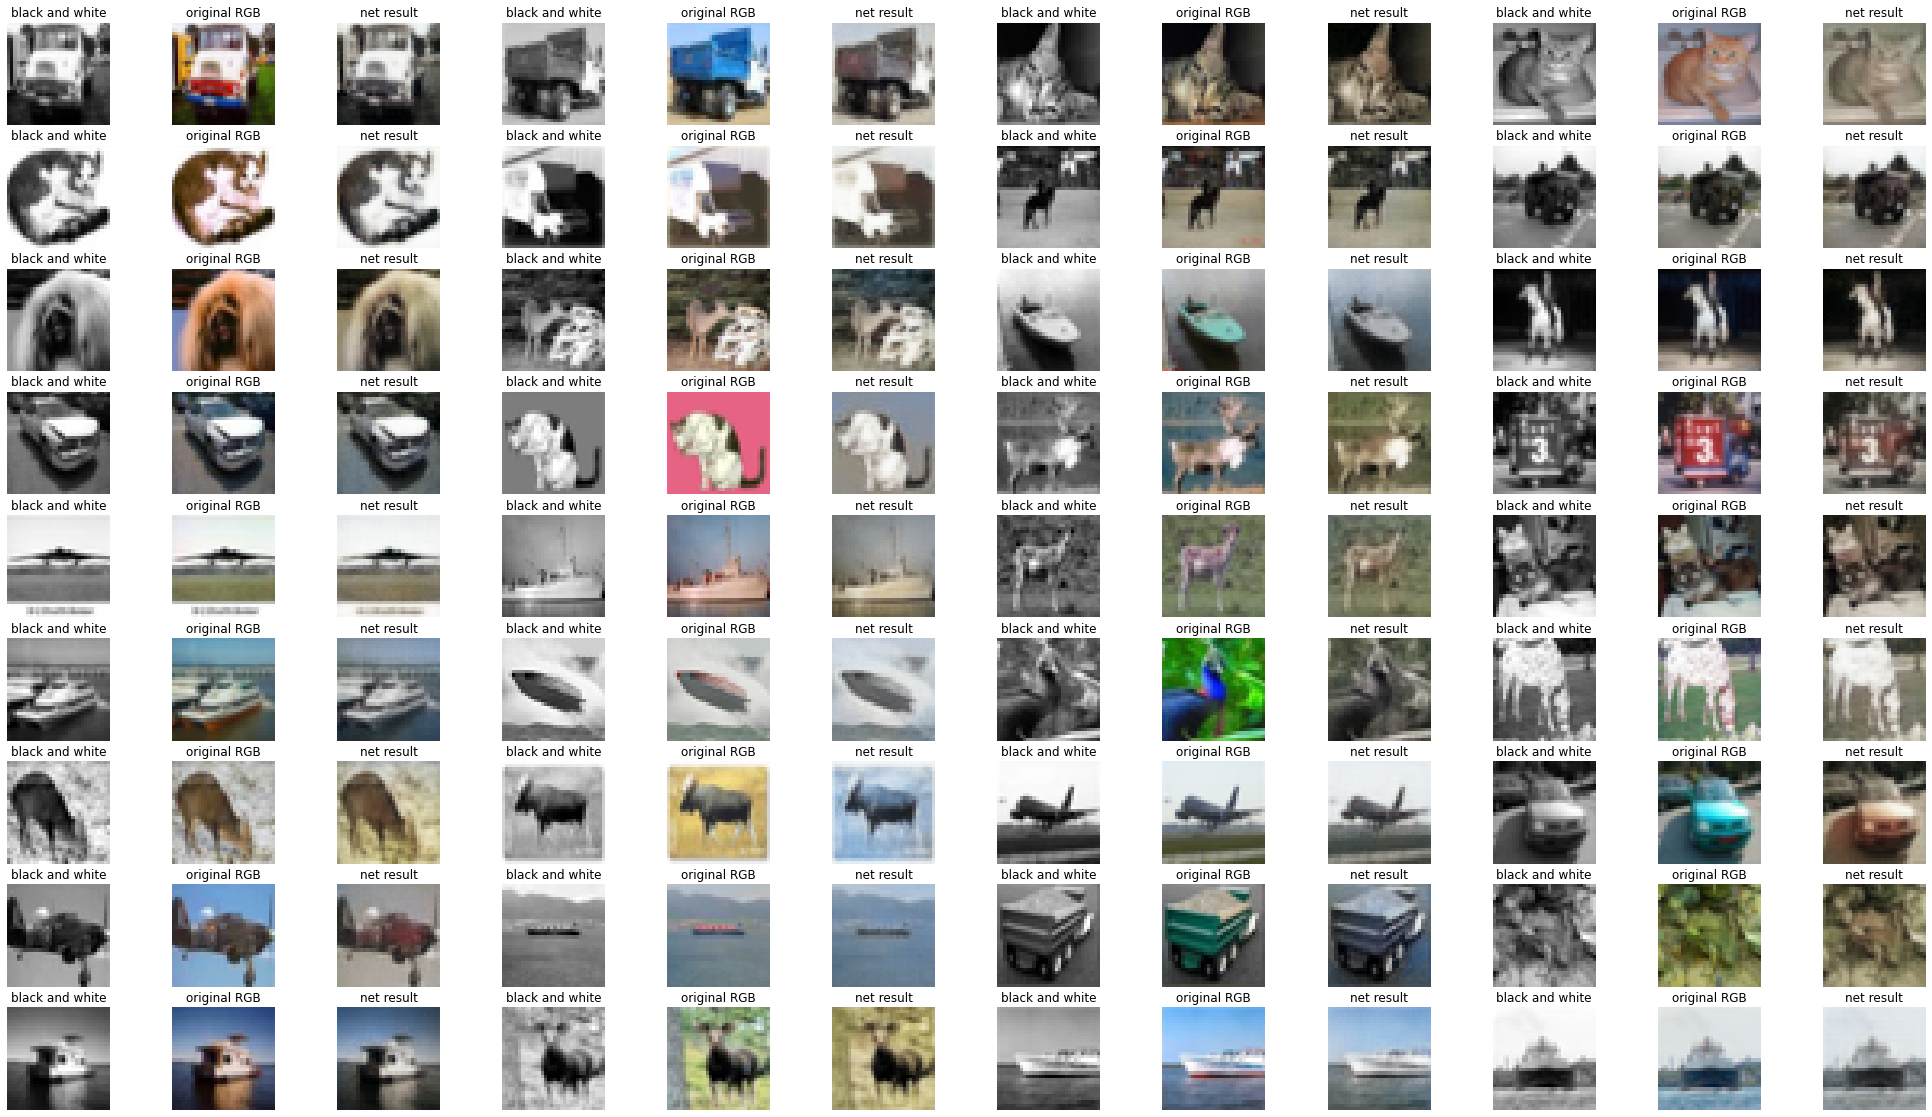

In [ ]:
import random

fig = plt.figure(figsize = (35,20))

cols, rows = 12, 9
for i in range(1, rows*cols+1,3):
    sample_idx = torch.randint(len(test_net_res), size=(1,)).item()
    bw_img, rgb_image,net_res = test_net_res[sample_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow((bw_img.cpu().clone()).numpy().reshape(32,32),cmap='gray')
    plt.title("black and white")
    plt.axis("off")
    fig.add_subplot(rows, cols, i+1)
    plt.imshow((rgb_image.cpu().clone()).permute(1, 2, 0).numpy())
    plt.title("original RGB")
    plt.axis("off")
    fig.add_subplot(rows, cols, i+2)
    plt.imshow((net_res.cpu().clone()).permute(1, 2, 0).numpy())
    plt.title("net result")
    plt.axis("off")
plt.show()